In [3]:

import numpy as np
import pandas as pd
from numpy import loadtxt
import os
import datetime
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
from numpy.random import seed

RANDOM_SEED = 123

In [4]:
seed(RANDOM_SEED)

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.neighbors import kneighbors_graph
import pandas as pd
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from keras.models import load_model
from sklearn.cluster import KMeans

import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

RANDOM_SEED = 123
seed(RANDOM_SEED)


from scipy import sparse
from scipy import linalg
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [ ]:

# %%
# Read data
dataset_0 = pd.read_csv('DetalleVentas.csv', dtype={'SKU': str, 'LOC': str})


In [5]:

cat = pd.read_csv('Catalogo.csv', dtype={'Articulo': str, 'LOC': str})

# # Format
#
# dataset_0['FECHA'] = pd.to_datetime(dataset_0['FECHA'])
# dataset_0 = dataset_0.astype({"UNI": float})
# dataset_0.dtypes

locs = cat['LOC']
cat = cat.iloc[0:10, 0:5]
arts = cat['Articulo']

In [2]:

# Table form: Cases: Loc+Art, Predictors: Sales by date

# Dates
min_date = min(dataset_0['FECHA'])
max_date = max(dataset_0['FECHA'])
dates = pd.date_range(start=min_date, end=max_date)

# Matrix
nrows = locs.size * arts.size
ncols = dates.size
dataset = np.zeros(shape=(nrows, ncols))

ART = "SKU"
LOC = "LOC"
FECHA = 'FECHA'
UNI = 'UNI'
i = 0

for art in arts:
    for loc in locs:
        dataset_row = np.zeros(ncols)
        info = dataset_0[(dataset_0[ART] == art) & (dataset_0[LOC] == loc)]
        for info_row in info.iterrows():
            date = info_row[1][FECHA]
            sale = info_row[1][UNI]
            idx_col = dates.get_loc(date)
            dataset_row[idx_col] = sale
        dataset[i, :] = dataset_row
        i += 1


dataset = pd.DataFrame(dataset)
dataset.columns = dates
i = 0
loc_names = ['loc']*nrows
art_names = ['art']*nrows
for loc in locs:
    for art in arts:
        loc_names[i] = loc
        art_names[i] = art
        i += 1


In [6]:
# %%

# Read data
inv = pd.read_csv('Inventario.csv', dtype={'SKU': str, 'LOC': str})
# Format
inv = inv.astype({"INVENTARIO_23_06_2019": int})

# Array
nrows = locs.size * arts.size
inv_vec = np.zeros(nrows)

ART = "SKU"
LOC = "LOC"
INV = "INVENTARIO_23_06_2019"
i = 0
for loc in locs:
    for art in arts:
        info = inv[(inv[ART] == art) & (inv[LOC] == loc)]
        if info.INVENTARIO_23_06_2019.size == 1 and art != 'Art04':
            inv_vec[i] = info[INV]
        i += 1

np.savetxt('vec_inventario.txt', inv_vec)

Explore Data

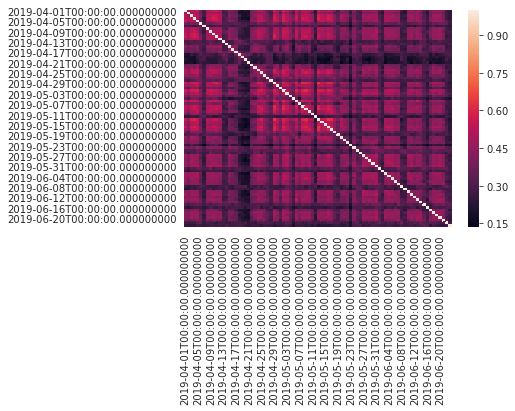

In [3]:
# Correlations

corr = dataset.corr()
ax = sns.heatmap(corr)


/home/andrea/anaconda3/envs/xai/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


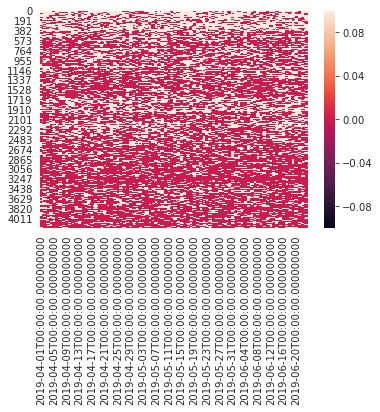

In [4]:
sns.heatmap(np.log(dataset))

In [19]:
# Projection + clustering

from collections import defaultdict

# Visualization

def add_continuous_colored_scatter_plot_to_fig(x, y, colors, rows, columns, n_sub_fig, fig, title):
    ax = fig.add_subplot(rows, columns, n_sub_fig)
    ax.set_title(title)

    # cmap = sns.cubehelix_palette(as_cmap=True)
    points = ax.scatter(x, y, c=colors, s=80)  #, cmap=cmap)
    fig.colorbar(points, ax=ax)

def add_colored_scatter_plot_to_fig(x, y, colors, rows, columns, n_sub_fig, fig, title):
    ax = fig.add_subplot(rows, columns, n_sub_fig)
    ax.set_title(title)
    sns.scatterplot(x=x, y = y, c=colors, s=80, ax=ax)

def clusters_to_colors(clusters):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(clusters))
    print('num_classes', num_classes)
    palette = np.array(sns.color_palette("hls", num_classes))
    return palette

def attribute_to_numeric(attributes, unique_attributes):
    attr_to_num = defaultdict(int)
    for i, attr in enumerate(unique_attributes):
        attr_to_num[attr] = i*1.0
    return [attr_to_num[attr] for attr in attributes]

# Spectral Clustering

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian

def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)

    # Verify eigenvalues are real
    print("Imaginary values ", np.unique(np.imag(eigenvals)))

    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

def run_k_means(df, n_clusters):
    """K-means clustering."""
    k_means = KMeans(random_state=25, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster


def clusters_by_spectral_clustering(df, n_neighbors, n_clusters):
    """Spectral Clustering Algorithm."""
    graph_laplacian = generate_graph_laplacian(df, n_neighbors)
    eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)
    proj_df = project_and_transpose(eigenvals, eigenvcts, n_clusters)
    cluster = run_k_means(proj_df, proj_df.columns.size)

    return np.array(cluster)


In [25]:
def add_continuous_colored_scatter_plot_to_fig(x, y, colors, rows, columns, n_sub_fig, fig, title):
    ax = fig.add_subplot(rows, columns, n_sub_fig)
    ax.set_title(title)

    cmap = sns.cubehelix_palette(as_cmap=True)
    points = ax.scatter(x, y, c=colors, s=80, cmap=cmap)
    fig.colorbar(points, ax=ax)

def add_colored_scatter_plot_to_fig(x, y, colors, rows, columns, n_sub_fig, fig, title):
    ax = fig.add_subplot(rows, columns, n_sub_fig)
    ax.set_title(title)
    print(x)
    sns.scatterplot(x=x, y = y, c=colors, s=80, ax=ax)

def clusters_to_colors(clusters):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(clusters))
    palette = np.array(sns.color_palette("hls", num_classes))
    return palette[clusters.astype(np.int)]

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian

def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)

    # Verify eigenvalues are real
    print("Imaginary values ", np.unique(np.imag(eigenvals)))

    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

def run_k_means(df, n_clusters):
    """K-means clustering."""
    k_means = KMeans(random_state=25, n_clusters=n_clusters)
    k_means.fit(df)
    cluster = k_means.predict(df)
    return cluster


def clusters_by_spectral_clustering(df, n_neighbors, n_clusters):
    """Spectral Clustering Algorithm."""
    graph_laplacian = generate_graph_laplacian(df, n_neighbors)
    eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)
    proj_df = project_and_transpose(eigenvals, eigenvcts, n_clusters)
    cluster = run_k_means(proj_df, proj_df.columns.size)

    return np.array(cluster)

In [6]:
# T-SNE Location Articles
best_perplexity_art = 40
best_perplexity_loc = 13
perplexitys = [best_perplexity_art, best_perplexity_loc]
perp_proy_dict = dict()
for k, perplexity in enumerate(perplexitys):
    print('perplexity:', perplexity)
    proy = TSNE(random_state=RANDOM_SEED, perplexity=perplexity).fit_transform(dataset)
    perp_proy_dict[perplexity] = proy

('perplexity:', 40)
('perplexity:', 13)


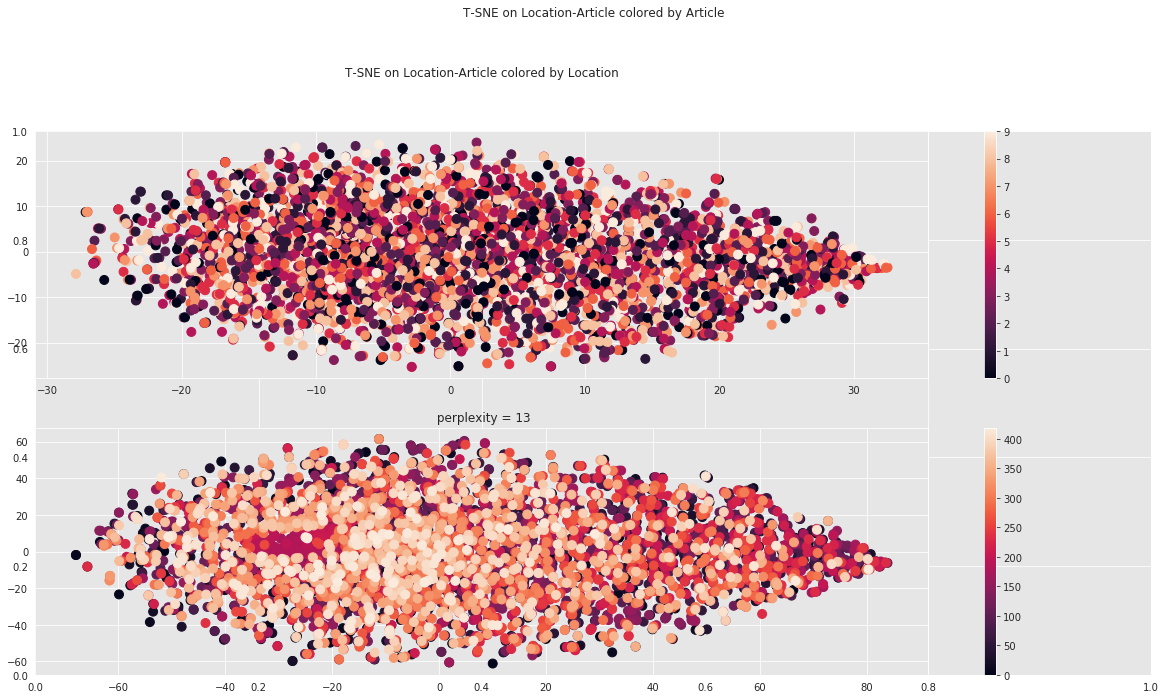

In [7]:
# Visualize the best perplexities for articles
rows = 2
columns = (len(perplexitys)+1)/2
fig  = plt.figure(figsize = (20, 10))
colors2 = attribute_to_numeric(art_names, arts)
colors1 = attribute_to_numeric(loc_names, locs)
colors = [colors2, colors1]
color_cat = ['Article', 'Location']


k=0
for perplexity, proy in perp_proy_dict.items():
    plt.title("T-SNE on Location-Article colored by "+ color_cat[k] , y=1.2)

    add_continuous_colored_scatter_plot_to_fig(proy[:,0], proy[:,1], colors[k], rows, columns, k+1, fig,
                                " perplexity = "+str(perplexity))
    k += 1



In [21]:
neighbors_opt = [5, 10, 30, 50]

# Clustering
n_clusters = {perplexitys[0]: 10, perplexitys[1]: 6}
# Clustering visualization
perp_clus_dict = defaultdict(lambda : [])
perp_colors_dict = defaultdict(lambda : [])

for perp in perplexitys:
    proy = perp_proy_dict[perp]
    print('perp: ', perp)
    for k, n_neighbors in enumerate(neighbors_opt):
        print('n_neighbors: ', n_neighbors)
        clusters = clusters_by_spectral_clustering(dataset, n_neighbors, n_clusters[perp])
        colors = clusters_to_colors(clusters)
        perp_clus_dict[perp].append(clusters)
        perp_colors_dict[perp].append(colors)

('perp: ', 40)
('n_neighbors: ', 5)
('Imaginary values ', array([0.]))
('num_classes', 10)
('n_neighbors: ', 10)
('Imaginary values ', array([0.]))
('num_classes', 10)
('n_neighbors: ', 30)
('Imaginary values ', array([0.]))
('num_classes', 10)
('n_neighbors: ', 50)
('Imaginary values ', array([0.]))
('num_classes', 10)
('perp: ', 13)
('n_neighbors: ', 5)
('Imaginary values ', array([0.]))
('num_classes', 6)
('n_neighbors: ', 10)
('Imaginary values ', array([0.]))
('num_classes', 6)
('n_neighbors: ', 30)
('Imaginary values ', array([0.]))
('num_classes', 6)
('n_neighbors: ', 50)
('Imaginary values ', array([0.]))
('num_classes', 6)


('n_neighbors: ', 5)
(4200,)
[ 62.3061    31.769812  23.924858 ... -24.987347 -24.65744   80.284485]


ValueError: c of shape (4200,) not acceptable as a color sequence for x with size 0, y with size 0

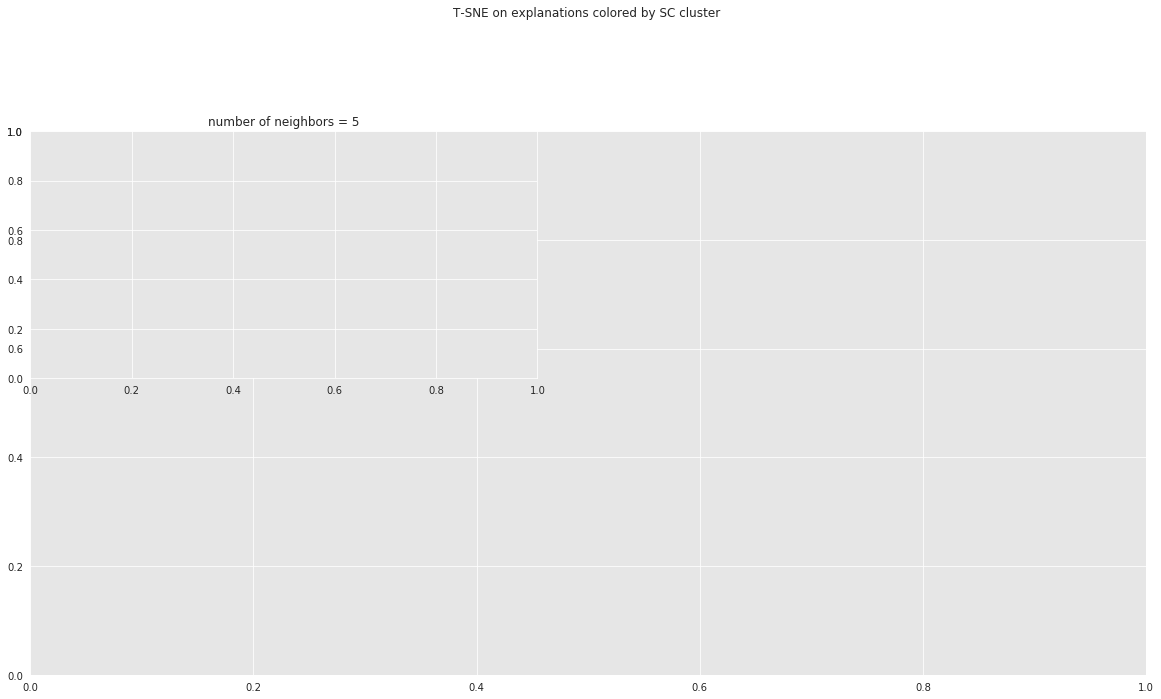

In [26]:

rows = 2
columns = (len(neighbors_opt)+1)/2
fig  = plt.figure(figsize = (20, 10))
plt.title("T-SNE on explanations colored by SC cluster ", y=1.2)


# Clustering visualization

perp = best_perplexity_loc
proy = perp_proy_dict[perp]
clusters_s = perp_clus_dict[perp]
colors_s = perp_clus_dict[perp]

for k, n_neighbors in enumerate(neighbors_opt):
    print('n_neighbors: ', n_neighbors)
    clusters = clusters_s[k]
    print(clusters.shape)
    colors = colors_s[k]
    add_colored_scatter_plot_to_fig(proy[:,0], proy[:,1], colors, rows, columns, k+1, fig,
                                    "number of neighbors = "+str(n_neighbors))

('Imaginary values ', array([0.]))
('num_classes', 5)


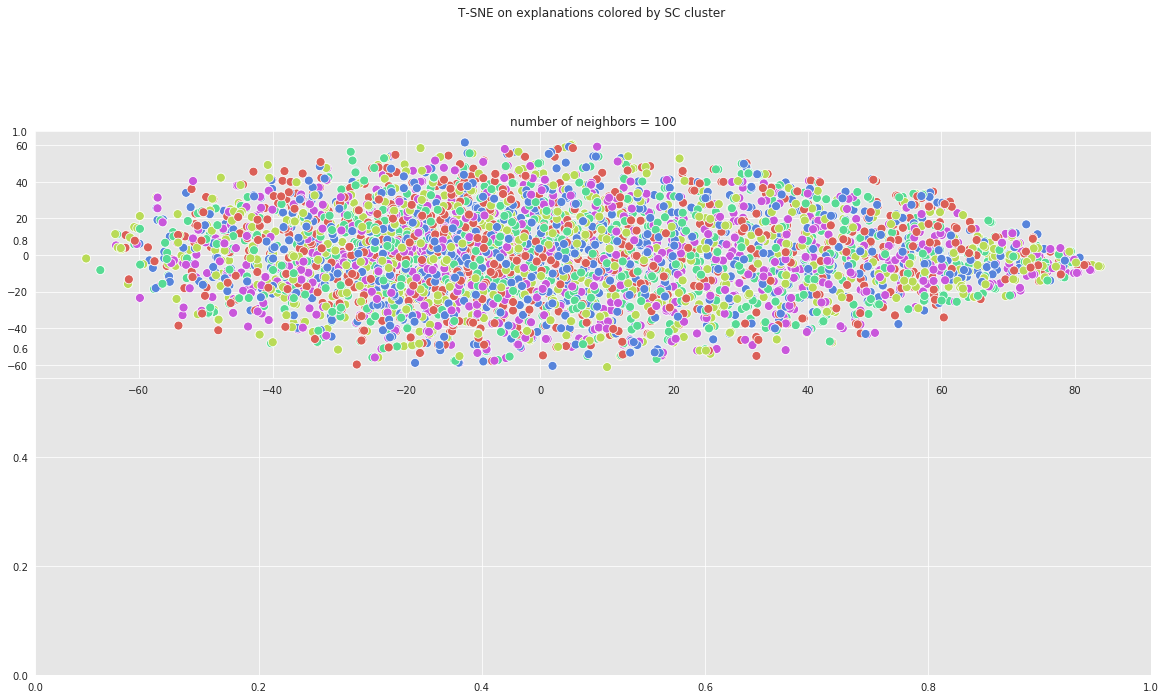

In [20]:
neighbors_opt = [100]
rows = 2
columns = (len(neighbors_opt)+1)/2
fig  = plt.figure(figsize = (20, 10))
plt.title("T-SNE on explanations colored by SC cluster ", y=1.2)

# Clustering
n_clusters = 5
perp = best_perplexity_loc
n_clusters = 5
proy = perp_proy_dict[perp]

# Clustering visualization
for k, n_neighbors in enumerate(neighbors_opt):
    clusters = clusters_by_spectral_clustering(dataset, n_neighbors, n_clusters)
    colors = clusters_to_colors(clusters)
    add_colored_scatter_plot_to_fig(proy[:,0], proy[:,1], colors, rows, columns, k+1, fig,
                                    "number of neighbors = "+str(n_neighbors))

In [ ]:
neighbors_opt = [5, 10, 20, 30, 40, 50]
rows = 2
columns = (len(neighbors_opt)+1)/2
fig  = plt.figure(figsize = (20, 10))
plt.title("T-SNE on  explanations colored by SC cluster ", y=1.2)

# Clustering
n_clusters = 5
perp = best_perplexity_loc
n_clusters = 5
proy = perp_proy_dict[perp]


# Clustering visualization
for k, n_neighbors in enumerate(neighbors_opt):
    clusters = clusters_by_spectral_clustering(dataset, n_neighbors, n_clusters)
    colors = clusters_to_colors(clusters)
    add_colored_scatter_plot_to_fig(proy[:,0], proy[:,1], colors, rows, columns, k+1, fig,
                                    "number of neighbors = "+str(n_neighbors))